In [0]:
!pip install transformers

In [0]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [0]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Import Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/test_nlp/train_set.csv', index_col='id')
test = pd.read_csv('/content/drive/My Drive/test_nlp/validation_set.csv', index_col='id')

In [0]:
train.head()

,cleaned_plots,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,Indie,Action/Adventure,Adventure,Family Film,Short Film,Romantic drama,Animation,Musical,Science Fiction,Mystery,Romantic comedy,Fantasy,Comedy film,Crime Thriller,War film,Period piece,Japanese Movies,Comedy-drama,Film adaptation,Documentary,Silent film,Psychological thriller,Bollywood,Western,Chinese Movies,Black comedy,LGBT,Teen,Parody,Family Drama,Children's/Family,Coming of age,Martial Arts Film,Cult,Sports,Television movie,Slasher,Suspense,Biographical film,Biography,Supernatural
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3027912,jesse reilly released prison married hope shor...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74956,trudy kockenlocker small town girl soft spot s...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
23680613,bok nyeo mentally handicapped woman supports l...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8337507,singer named emmy meets broken journalist hank...,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17136700,taipei team ghost hunters pay freelance camera...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
test.head()

,cleaned_plots,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,Indie,Action/Adventure,Adventure,Family Film,Short Film,Romantic drama,Animation,Musical,Science Fiction,Mystery,Romantic comedy,Fantasy,Comedy film,Crime Thriller,War film,Period piece,Japanese Movies,Comedy-drama,Film adaptation,Documentary,Silent film,Psychological thriller,Bollywood,Western,Chinese Movies,Black comedy,LGBT,Teen,Parody,Family Drama,Children's/Family,Coming of age,Martial Arts Film,Cult,Sports,Television movie,Slasher,Suspense,Biographical film,Biography,Supernatural
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4343361,alex kovac playing poker new york city drops g...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4730,gotham city batman stops hostage situation ban...,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32037191,small town guy tries decide staying current gi...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27376549,montreal west high school student leon bronste...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
18586060,ice people brings anne aghion crew antarctica ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocess Data

In [0]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of plots Embeddings");
    ax.set_ylabel("Number of plots");
    return

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [0]:
train_text_list = train["cleaned_plots"].values
test_text_list = test["cleaned_plots"].values

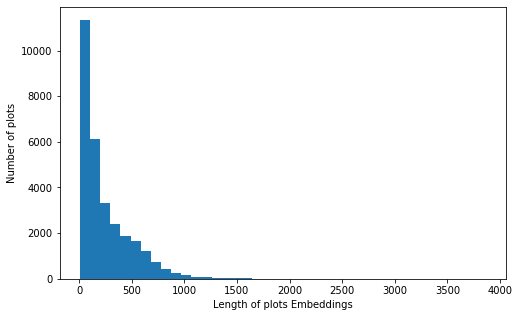

In [0]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

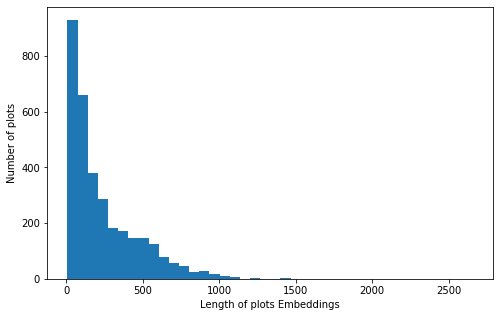

In [0]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [0]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [0]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=500)
train_input_ids

array([[   17,  1315, 16838, ...,     0,     0,     0],
       [   17,  6380,  2087, ...,     0,     0,     0],
       [   17,  1238,   267, ...,     0,     0,     0],
       ...,
       [  468,  3030,  3830, ...,     0,     0,     0],
       [   17,   661,  3417, ...,     0,     0,     0],
       [ 4487,  2647,  4994, ...,    17,     4,     3]])

In [0]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=500)
test_input_ids

array([[   24, 12683,    17, ...,     0,     0,     0],
       [  345,  1714,   285, ...,     0,     0,     0],
       [  316,   584,  2035, ...,     0,     0,     0],
       ...,
       [  468,  2848,   139, ...,     0,     0,     0],
       [18850,    23,   199, ...,     0,     0,     0],
       [  484,   399,   185, ...,     0,     0,     0]])

In [0]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)

In [0]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)

In [0]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [0]:
train.head()

,cleaned_plots,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,Indie,Action/Adventure,Adventure,Family Film,Short Film,Romantic drama,Animation,Musical,Science Fiction,Mystery,Romantic comedy,Fantasy,Comedy film,Crime Thriller,War film,Period piece,Japanese Movies,Comedy-drama,Film adaptation,Documentary,Silent film,Psychological thriller,Bollywood,Western,Chinese Movies,Black comedy,LGBT,Teen,Parody,Family Drama,Children's/Family,Coming of age,Martial Arts Film,Cult,Sports,Television movie,Slasher,Suspense,Biographical film,Biography,Supernatural,features,masks
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3027912,jesse reilly released prison married hope shor...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[17, 1315, 16838, 17, 88, 902, 111, 528, 1840,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
74956,trudy kockenlocker small town girl soft spot s...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"[17, 6380, 2087, 17, 1507, 16014, 4209, 118, 3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
23680613,bok nyeo mentally handicapped woman supports l...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[17, 1238, 267, 17, 2159, 6122, 11023, 26605, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8337507,singer named emmy meets broken journalist hank...,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[3592, 812, 10519, 2239, 5971, 2660, 5136, 17,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
17136700,taipei team ghost hunters pay freelance camera...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[17, 751, 20871, 150, 230, 8195, 16635, 616, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [0]:
test.head()

,cleaned_plots,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,Indie,Action/Adventure,Adventure,Family Film,Short Film,Romantic drama,Animation,Musical,Science Fiction,Mystery,Romantic comedy,Fantasy,Comedy film,Crime Thriller,War film,Period piece,Japanese Movies,Comedy-drama,Film adaptation,Documentary,Silent film,Psychological thriller,Bollywood,Western,Chinese Movies,Black comedy,LGBT,Teen,Parody,Family Drama,Children's/Family,Coming of age,Martial Arts Film,Cult,Sports,Television movie,Slasher,Suspense,Biographical film,Biography,Supernatural,features,masks
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4343361,alex kovac playing poker new york city drops g...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[24, 12683, 17, 19281, 369, 945, 2953, 109, 24...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4730,gotham city batman stops hostage situation ban...,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[345, 1714, 285, 6842, 249, 7640, 8840, 1023, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
32037191,small town guy tries decide staying current gi...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[316, 584, 2035, 5003, 2263, 5909, 604, 8224, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
27376549,montreal west high school student leon bronste...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"[17, 4960, 5550, 1750, 227, 297, 1190, 17, 529...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
18586060,ice people brings anne aghion crew antarctica ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[2528, 104, 4377, 17, 11483, 17, 9070, 960, 24...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## Train, Valid Split

In [0]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [0]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = list(train.columns[1:-2])
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [0]:
print(Y_train[0])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
print(len(Y_train[0]))

50


## Create Dataloaders

In [0]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [0]:
# Select a batch size for training
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [0]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

      if step % 50 == 0:
        loss_data = loss.item()
        print(
        'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
        format(actual_epoch, step * len(batch[0]), len(train_dataloader.dataset),
        100. * step / len(train_dataloader), loss_data))


    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

## Train Model from Scratch

In [0]:
torch.cuda.empty_cache()

In [0]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [0]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/test_nlp/xlnet_movie_genre_500.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train Epoch: 0 [0/23844 (0%)]	Loss: 1.814003
Train Epoch: 0 [400/23844 (2%)]	Loss: 0.210652
Train Epoch: 0 [800/23844 (3%)]	Loss: 0.240816
Train Epoch: 0 [1200/23844 (5%)]	Loss: 0.186503
Train Epoch: 0 [1600/23844 (7%)]	Loss: 0.220881
Train Epoch: 0 [2000/23844 (8%)]	Loss: 0.158820
Train Epoch: 0 [2400/23844 (10%)]	Loss: 0.172188
Train Epoch: 0 [2800/23844 (12%)]	Loss: 0.258573
Train Epoch: 0 [3200/23844 (13%)]	Loss: 0.196643
Train Epoch: 0 [3600/23844 (15%)]	Loss: 0.261283
Train Epoch: 0 [4000/23844 (17%)]	Loss: 0.173891
Train Epoch: 0 [4400/23844 (18%)]	Loss: 0.243951
Train Epoch: 0 [4800/23844 (20%)]	Loss: 0.232288
Train Epoch: 0 [5200/23844 (22%)]	Loss: 0.247496
Train Epoch: 0 [5600/23844 (23%)]	Loss: 0.189078
Train Epoch: 0 [6000/23844 (25%)]	Loss: 0.264071
Train Epoch: 0 [6400/23844 (27%)]	Loss: 0.215906
Train Epoch: 0 [6800/23844 (29%)]	Loss: 0.133289
Train Epoch: 0 [7200/23844 (30%)]	Loss: 0.134422
Train Epoch: 0 [7600/23844 (32%)]	Loss: 0.198741
Train Epoch: 0 [8000/23844 (34%

Epoch:  33%|███▎      | 1/3 [1:39:05<3:18:11, 5945.80s/it]

Saving model at epoch 0 with validation loss of 0.017801938642844864


Train Epoch: 1 [0/23844 (0%)]	Loss: 0.189772


KeyboardInterrupt: ignored

In [0]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Train Model From Previous Checkpoint

In [0]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/test_nlp/xlnet_movie_genre.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [0]:
num_epochs=1
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch: 0 [0/23844 (0%)]	Loss: 0.121544
Train Epoch: 0 [400/23844 (2%)]	Loss: 0.179217
Train Epoch: 0 [800/23844 (3%)]	Loss: 0.166988
Train Epoch: 0 [1200/23844 (5%)]	Loss: 0.148867
Train Epoch: 0 [1600/23844 (7%)]	Loss: 0.137035
Train Epoch: 0 [2000/23844 (8%)]	Loss: 0.123010
Train Epoch: 0 [2400/23844 (10%)]	Loss: 0.143918
Train Epoch: 0 [2800/23844 (12%)]	Loss: 0.166311
Train Epoch: 0 [3200/23844 (13%)]	Loss: 0.184614
Train Epoch: 0 [3600/23844 (15%)]	Loss: 0.139583
Train Epoch: 0 [4000/23844 (17%)]	Loss: 0.170395
Train Epoch: 0 [4400/23844 (18%)]	Loss: 0.151211
Train Epoch: 0 [4800/23844 (20%)]	Loss: 0.161168
Train Epoch: 0 [5200/23844 (22%)]	Loss: 0.145188
Train Epoch: 0 [5600/23844 (23%)]	Loss: 0.134771
Train Epoch: 0 [6000/23844 (25%)]	Loss: 0.127737
Train Epoch: 0 [6400/23844 (27%)]	Loss: 0.164357
Train Epoch: 0 [6800/23844 (29%)]	Loss: 0.121776
Train Epoch: 0 [7200/23844 (30%)]	Loss: 0.130027
Train Epoch: 0 [7600/23844 (32%)]	Loss: 0.140810
Train Epoch: 0 [8000/23844 (34%

Epoch: 100%|██████████| 1/1 [1:37:30<00:00, 5850.20s/it]

Saving model at epoch 0 with validation loss of 0.017161018904629708




Text(0.5, 1.0, 'Loss vs Number of Epochs')

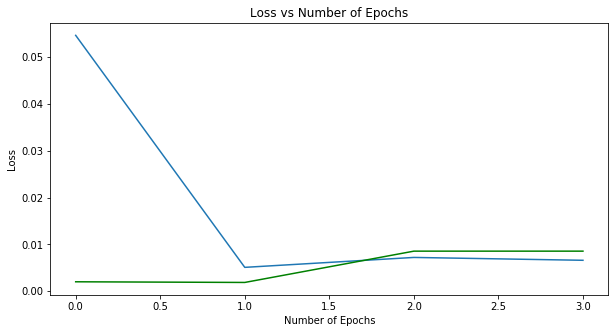

In [0]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Get Predictions

In [0]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])

    print(
        'Prediction step: {}/{}'.format(i,num_iter)
    )
  
  return pred_probs

In [0]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

Prediction step: 0/104
Prediction step: 1/104
Prediction step: 2/104
Prediction step: 3/104
Prediction step: 4/104
Prediction step: 5/104
Prediction step: 6/104
Prediction step: 7/104
Prediction step: 8/104
Prediction step: 9/104
Prediction step: 10/104
Prediction step: 11/104
Prediction step: 12/104
Prediction step: 13/104
Prediction step: 14/104
Prediction step: 15/104
Prediction step: 16/104
Prediction step: 17/104
Prediction step: 18/104
Prediction step: 19/104
Prediction step: 20/104
Prediction step: 21/104
Prediction step: 22/104
Prediction step: 23/104
Prediction step: 24/104
Prediction step: 25/104
Prediction step: 26/104
Prediction step: 27/104
Prediction step: 28/104
Prediction step: 29/104
Prediction step: 30/104
Prediction step: 31/104
Prediction step: 32/104
Prediction step: 33/104
Prediction step: 34/104
Prediction step: 35/104
Prediction step: 36/104
Prediction step: 37/104
Prediction step: 38/104
Prediction step: 39/104
Prediction step: 40/104
Prediction step: 41/104
Pr

array([[8.42682719e-01, 2.24900439e-01, 1.36145800e-01, ...,
        2.09049545e-02, 1.78369898e-02, 3.60704871e-04],
       [1.62539378e-01, 3.63706112e-01, 1.80296861e-02, ...,
        1.86391640e-03, 1.06397294e-03, 4.86513367e-03],
       [3.96124482e-01, 1.12068251e-01, 9.28311944e-02, ...,
        1.11573737e-03, 4.07725078e-04, 7.39491777e-03],
       ...,
       [8.84905040e-01, 1.47440985e-01, 2.66187340e-02, ...,
        1.88089497e-02, 9.02310479e-03, 3.12769058e-04],
       [2.90440828e-01, 6.11223996e-01, 1.33027658e-01, ...,
        1.35988439e-03, 1.90116430e-03, 3.51156952e-04],
       [6.17562056e-01, 4.48999345e-01, 2.52289802e-01, ...,
        2.19429322e-02, 7.64842890e-03, 9.59581012e-05]])

In [0]:
results = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'F1_score'])
for treshold in np.arange(0.1,0.9,0.1):
  predictions = np.where(pred_probs >= treshold, 1, 0)
  ground_truth = test.iloc[:,1:-2].values
  score = precision_recall_fscore_support(ground_truth, predictions, average='macro')
  results = results.append({'threshold': treshold, 'precision': score[0], 'recall':score[1],
                            'F1_score':score[2]} , ignore_index=True)
  print(score)
results.set_index('threshold', drop=True, inplace=True)

(0.29084621826522405, 0.6658102316407288, 0.389628520175171, None)
(0.38346722308486647, 0.5065732365485495, 0.4078849749328359, None)
(0.43295200174413445, 0.4056315905884506, 0.38045589214733794, None)
(0.47336914327729496, 0.33085861416710566, 0.34524734491381154, None)
(0.5103953197769602, 0.2763757846877261, 0.313892304536924, None)
(0.4496542883169894, 0.22280561873204857, 0.271257389503965, None)
(0.4389953463030679, 0.1752902338003428, 0.22888580054115548, None)
(0.4720213135625378, 0.1264012612326634, 0.17948948756658314, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([<matplotlib.axis.YTick at 0x7f0ccf460780>,
 <a list of 11 Text yticklabel objects>)

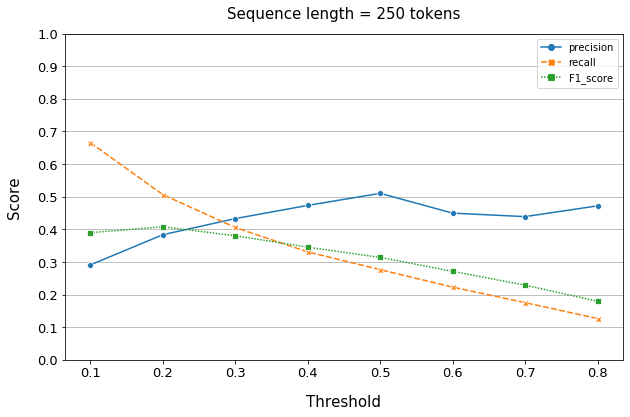

In [0]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=results, markers=True, ax=ax)
ax.yaxis.grid(True)
ax.set_title('Sequence length = 250 tokens', fontsize=15, pad=15)
ax.set_xlabel('Threshold', fontsize=15, labelpad=15)
ax.set_ylabel('Score', fontsize=15, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.yticks(np.arange(0, 1.1, 0.1))

In [0]:
  predictions = np.where(pred_probs >= 0.2, 1, 0)
  ground_truth = test.iloc[:,1:-2].values
  score = pd.DataFrame(precision_recall_fscore_support(ground_truth, predictions, average=None)).T
  score.columns = ['precision', 'recall', 'F1_score', 'count']
  score.index = test.columns[1:-2]

In [0]:
def score_vis(score):
    precision = score['precision'].sort_index()
    recall = score['recall'].sort_index()
    nb = score['count'].sort_index()
    
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, figsize=(20,12))
    
    sns.barplot(x=precision.index, y=precision.values, ax=ax0)
    ax0.set_title('Precision', pad=15, fontsize=20)
    ax0.set_ylabel('Precision', fontsize=15, labelpad=15)
    
    sns.barplot(x=recall.index, y=recall.values, ax=ax1)
    ax1.set_title('Recall', pad=15, fontsize=20)
    ax1.set_ylabel('Recall', fontsize=15, labelpad=15)
    
    sns.barplot(x=nb.index, y=nb.values, ax=ax2)
    ax2.set_title('Count', pad=15, fontsize=20)
    ax2.set_ylabel('Count', fontsize=15, labelpad=15) 
    
    plt.xticks(rotation='vertical')

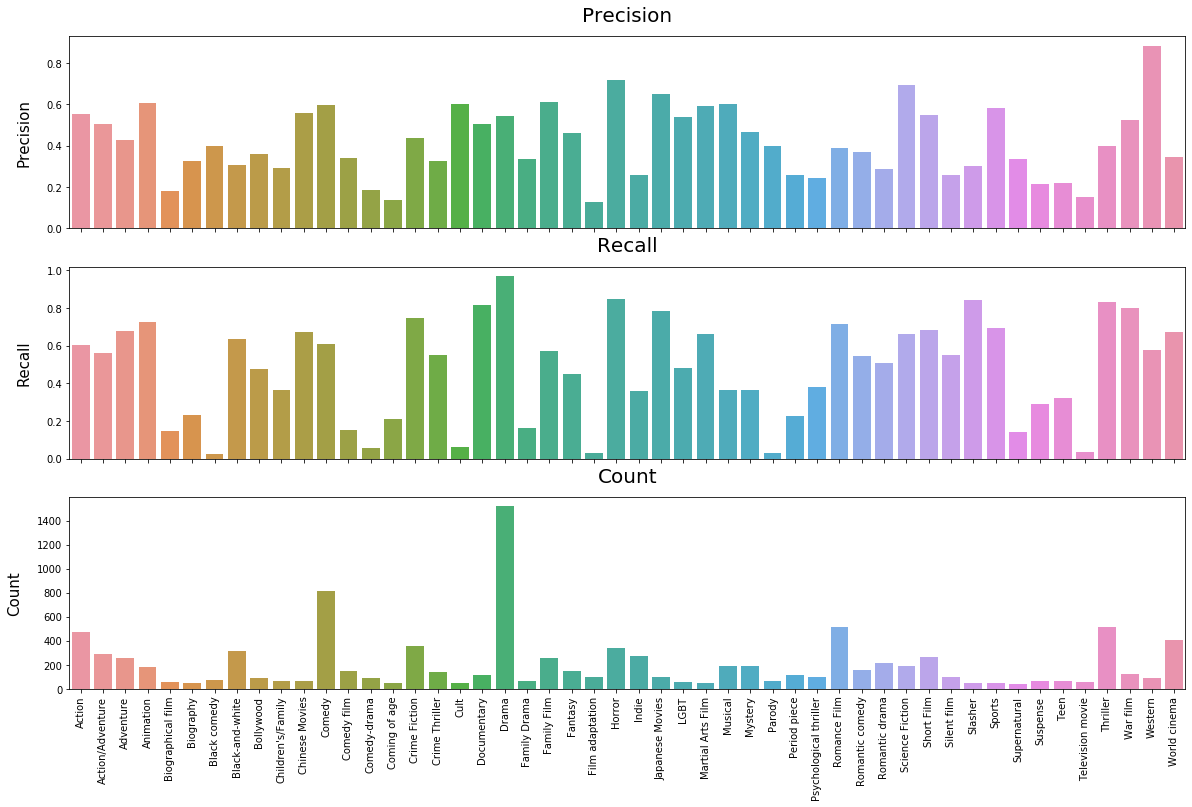

In [0]:
score_vis(score)

In [0]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Data/toxic_1_epoch.csv")
test_to_csv[["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_csv(pred_save_path, index=False)

In [0]:
np.round(pred_probs)